In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle
from scipy.ndimage import median_filter
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
!gdown --id 12DWmjL6LNLsNye-3o-il-Hw4GDgu6yOh
!unzip -q /content/Dataset5000.zip -d /content/dataset

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=12DWmjL6LNLsNye-3o-il-Hw4GDgu6yOh
From (redirected): https://drive.google.com/uc?id=12DWmjL6LNLsNye-3o-il-Hw4GDgu6yOh&confirm=t&uuid=2d3cedc4-eda5-4e3d-864f-e2199069e42c
To: /content/Dataset5000.zip
100% 590M/590M [00:11<00:00, 52.0MB/s]


In [ ]:
import os
import shutil
import tensorflow as tf

# Define your dataset path
dataset_path = "/content/dataset/Dataset5000"
output_path = "/content/dataset/selected_images"

# Create output directories
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=64,
    label_mode='int',
    shuffle=True,
    seed=42
)

# Get class names
class_names = dataset.class_names

# Process each class
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(output_path, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

    # Track the number of images copied
    count = 0

    for images, labels in dataset:
        for i in range(images.shape[0]):
            if count < 100 and labels[i].numpy() == class_index:
                # Save the image
                img = tf.keras.preprocessing.image.array_to_img(images[i])
                img.save(os.path.join(class_folder, f"{class_name}_{count}.jpg"))
                count += 1

            if count >= 100:
                break

        if count >= 100:
            break

print("Images have been saved.")


Found 5968 files belonging to 10 classes.
Images have been saved.


In [ ]:
dataset1000 = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/selected_images",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True,
    seed=42
)


Found 1000 files belonging to 10 classes.


In [ ]:

num_batches = tf.data.experimental.cardinality(dataset1000).numpy()

train_size = int(0.8 * num_batches)
val_size = int(0.1 * num_batches)
test_size = num_batches - train_size - val_size


train_dataset = dataset1000.take(train_size)
val_dataset = dataset1000.skip(train_size).take(val_size)
test_dataset = dataset1000.skip(train_size + val_size)

In [ ]:

class_counts = {}

for images, labels in test_dataset:
    for label in labels.numpy():
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1


class_counts = dict(sorted(class_counts.items()))


for class_label, count in class_counts.items():
    print(f'Class {class_label}: {count} samples')

Class 0: 6 samples
Class 1: 10 samples
Class 2: 13 samples
Class 3: 6 samples
Class 4: 14 samples
Class 5: 8 samples
Class 6: 11 samples
Class 7: 11 samples
Class 8: 14 samples
Class 9: 11 samples


In [ ]:
import tensorflow as tf
import os

output_dir = "output_data"
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")


os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def save_dataset(dataset, output_path):
    class_counts = {}
    for i, (images, labels) in enumerate(dataset):
        for j in range(images.shape[0]):
            label = labels[j].numpy()
            label_dir = os.path.join(output_path, str(label))
            os.makedirs(label_dir, exist_ok=True)

            class_counts[label] = class_counts.get(label, 0) + 1

            img_path = os.path.join(label_dir, f"img_{i}_{j}.jpg")
            tf.keras.utils.save_img(img_path, images[j].numpy())
    print(f"Saved data to {output_path}")
    for class_label, count in class_counts.items():
        print(f"Class {class_label}: {count} samples")


save_dataset(train_dataset, train_dir)
save_dataset(val_dataset, val_dir)
save_dataset(test_dataset, test_dir)


Saved data to output_data/train
Class 0: 81 samples
Class 4: 75 samples
Class 7: 74 samples
Class 9: 84 samples
Class 5: 77 samples
Class 8: 73 samples
Class 2: 84 samples
Class 3: 85 samples
Class 1: 82 samples
Class 6: 85 samples
Saved data to output_data/val
Class 9: 10 samples
Class 8: 14 samples
Class 6: 11 samples
Class 0: 7 samples
Class 2: 8 samples
Class 4: 10 samples
Class 3: 13 samples
Class 1: 8 samples
Class 5: 7 samples
Class 7: 8 samples
Saved data to output_data/test
Class 9: 11 samples
Class 6: 12 samples
Class 2: 6 samples
Class 0: 12 samples
Class 8: 8 samples
Class 3: 9 samples
Class 7: 14 samples
Class 1: 11 samples
Class 5: 13 samples
Class 4: 8 samples


# PREPROCESSING

In [ ]:
# LOAD AND RESIZE TO 224x224
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/output_data/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True,
    seed=42
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/output_data/val",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=True,
    seed=42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/output_data/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    shuffle=False,
    seed=42
)

Found 800 files belonging to 10 classes.
Found 96 files belonging to 10 classes.
Found 104 files belonging to 10 classes.


# MODEL

In [ ]:
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 338ms/step - accuracy: 0.1134 - loss: 2.3545 - val_accuracy: 0.3229 - val_loss: 2.0902
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.2482 - loss: 2.1344 - val_accuracy: 0.3542 - val_loss: 1.9349
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3046 - loss: 1.9818 - val_accuracy: 0.4167 - val_loss: 1.8261
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3824 - loss: 1.8564 - val_accuracy: 0.4583 - val_loss: 1.7540
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4003 - loss: 1.7966 - val_accuracy: 0.4896 - val_loss: 1.6945
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3957 - loss: 1.7589 - val_accuracy: 0.5104 - val_loss: 1.6584
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4336 - loss: 1.6925 - val_accuracy: 0.5312 - val_loss: 1.6140
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4695 - loss: 1.6073 - val_accuracy:

In [ ]:
def evaluate_model(dataset, model):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=-1)

        y_true.extend(labels.numpy())
        y_pred.extend(pred_labels)


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,average='weighted')
    recall = recall_score(y_true, y_pred,average='weighted')
    f1 = f1_score(y_true, y_pred,average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, cm

In [ ]:
test_acc, test_precision, test_recall, test_f1, cm = evaluate_model(test_data, model)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Test Accuracy: 0.7981
Test Precision: 0.8177
Test Recall: 0.7981
Test F1-Score: 0.7975


<Figure size 1000x800 with 0 Axes>

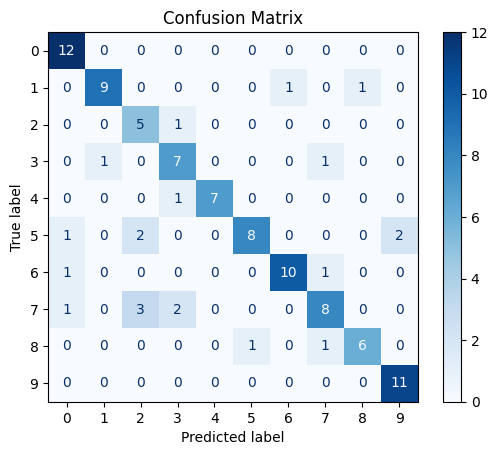

In [ ]:
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()